In [1]:
# Okay, let's build a simple version

# data_temp will contain 100 observations only
# goal is to predict the next observation (obs 101) - using neural network
# with some quantile interval - 0.25 to 0.75

In [2]:
import pandas as pd

In [3]:
Bitcoin = pd.read_csv('data/coin_Bitcoin.csv')

In [4]:
data_temp = Bitcoin.iloc[:100, :]
data_temp

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09
...,...,...,...,...,...,...,...,...,...,...
95,96,Bitcoin,BTC,2013-08-02 23:59:59,108.000000,101.210999,104.856003,104.500999,0.0,1.201487e+09
96,97,Bitcoin,BTC,2013-08-03 23:59:59,105.779999,102.001999,104.500999,104.004997,0.0,1.196227e+09
97,98,Bitcoin,BTC,2013-08-04 23:59:59,105.949997,103.523003,104.949997,105.143997,0.0,1.209797e+09
98,99,Bitcoin,BTC,2013-08-05 23:59:59,107.769997,105.000000,105.120003,106.220001,0.0,1.222677e+09


In [5]:
Bitcoin.iloc[100, :] # Actual Value is 106.75

SNo                          101
Name                     Bitcoin
Symbol                       BTC
Date         2013-08-07 23:59:59
High                      106.75
Low                       106.75
Open                      106.75
Close                     106.75
Volume                       0.0
Marketcap           1229098150.0
Name: 100, dtype: object

In [6]:
def tilted_loss(q, y, f):
    e = (y-f)
    return torch.mean(torch.max(q*e, (q-1)*e), dim=-1)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
features = data_temp[['High', 'Low', 'Open', 'Volume', 'Marketcap']].values
target = data_temp['Close'].values

In [9]:
X_train = torch.from_numpy(features)
y_train = torch.from_numpy(target)

In [10]:
X_train.shape

torch.Size([100, 5])

In [11]:
y_train.shape

torch.Size([100])

In [12]:
quantiles = [0.05, 0.25, 0.50, 0.75, 0.95]

input_size = X_train.shape[1]
hidden_size = 64
output_size = 5 # no. of quantiles = no. of output neurons

lr = 1e-2
num_epochs = 200

model = MLP(input_size, hidden_size, output_size).double()
opt = torch.optim.Adam(model.parameters(), lr=lr)

In [50]:
# Training loop
for epoch in range(num_epochs):

    # Zero the parameter gradients
    opt.zero_grad()

    # Forward pass
    y_pred = model(X_train)

    # Calculate loss
    loss = 0.0
    for i, q in enumerate(quantiles):
        loss += tilted_loss(q, y_train, y_pred[:, i])

    # Backward pass and optimization
    loss.backward()
    opt.step()

    # Print statistics
    running_loss = loss.item()
    print('[%d] loss: %.3f' %
            (epoch + 1, running_loss))

print('Finished Training')

[1] loss: 9493928.849
[2] loss: 9419824.946
[3] loss: 8947293.037
[4] loss: 8301216.269
[5] loss: 6170918.808
[6] loss: 8359854.081
[7] loss: 8565710.000
[8] loss: 8169051.127
[9] loss: 5518428.672
[10] loss: 7048769.673
[11] loss: 7414601.954
[12] loss: 10067294.702
[13] loss: 7662006.616
[14] loss: 4060636.196
[15] loss: 8684589.641
[16] loss: 10732703.288
[17] loss: 10336046.395
[18] loss: 7850922.107
[19] loss: 4856719.260
[20] loss: 4551368.085
[21] loss: 4202100.308
[22] loss: 4398144.931
[23] loss: 4250449.254
[24] loss: 4172870.359
[25] loss: 4462983.063
[26] loss: 4009544.912
[27] loss: 3443702.212
[28] loss: 3747991.737
[29] loss: 5206982.442
[30] loss: 4168644.525
[31] loss: 5224399.271
[32] loss: 5517242.695
[33] loss: 3904110.127
[34] loss: 5343995.512
[35] loss: 4893310.021
[36] loss: 5391875.445
[37] loss: 3887932.850
[38] loss: 5003275.918
[39] loss: 7503973.657
[40] loss: 6609572.880
[41] loss: 4629944.155
[42] loss: 3859494.955
[43] loss: 3548092.525
[44] loss: 608210

In [52]:
# should set a seed for reproducibility
import matplotlib.pyplot as plt

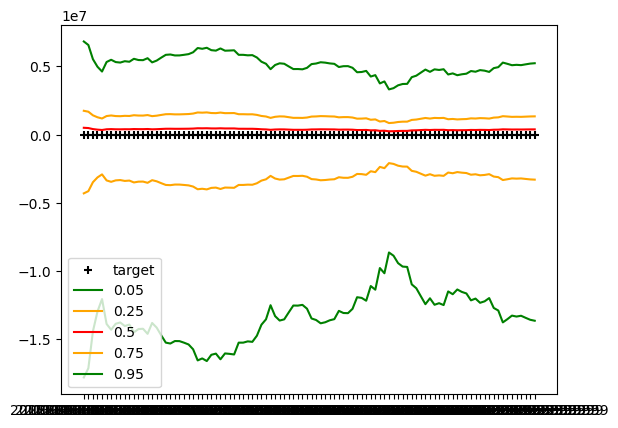

In [54]:
colors = ['green', 'orange', 'red', 'orange', 'green']
plt.scatter(data_temp['Date'], data_temp['Close'], color='black', marker='+', label='target')

for i, q in enumerate(quantiles):
    plt.plot(data_temp['Date'], y_pred.detach().numpy()[:, i], color=colors[i], label=q)

plt.legend()

In [16]:
# Next value (and its quantile interval)
'''
High                      106.75
Low                       106.75
Open                      106.75
Close                     106.75
Volume                       0.0
Marketcap           1229098150.0
'''

'\nHigh                      106.75\nLow                       106.75\nOpen                      106.75\nClose                     106.75\nVolume                       0.0\nMarketcap           1229098150.0\n'

In [56]:
# Example input data, should be in the shape (1, input_size)
# Replace this with your actual data
input_data = [105.75, 106.75, 106.75, 0, 1229098150]  # example data

# Convert the input data to a PyTorch tensor
input_tensor = torch.tensor([input_data], dtype=torch.double)

# Ensure the model is in evaluation mode
model.eval()

# Make the prediction
with torch.no_grad():  # Disable gradient calculation for inference
    prediction = model(input_tensor)

# The prediction is a tensor, you can convert it to a NumPy array or get the value
predicted_value = prediction.numpy()

print(f'Predicted value: {predicted_value}')

Predicted value: [[-12362830.51973229  -1688420.78878001  -1249611.06909291
    3034792.7600719    7865617.42794717]]


In [18]:
# Interpretation:
    # 5th percentile = -12.4M
    # 25th percentile = -1.7M
    # 50th percentile = -1.2M (Median)
    # 75th percentile = 3M
    # 95th percentile = 7.9M